# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()  #NomImageBase
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery]) #NomImageBase
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [2]:
def quantize(v, k):
    """ float*int -> int 
    """
    if v == 1:
        return int(k-1)
    
    return int(v*k)
        
    
# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()


2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [3]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    
    n,m, channels = I.shape
    Iq = np.zeros((I.shape))
    
    hist = np.zeros((nH, nS, nV), dtype='int')
      
    for x in range(n):
        for y in range(m):
                h=Iq[x,y,0] = quantize(I[x,y,0], nH)
                s=Iq[x,y,1] = quantize(I[x,y,1], nS)
                v=Iq[x,y,2] = quantize(I[x,y,2], nV)
                
                hist[h,s,v] += 1
    
    return Iq, hist


3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H, 2)


4) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


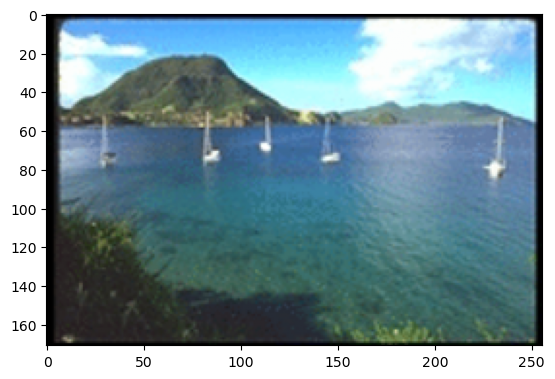

palette:  (288, 3)


C:\Users\giuli\AppData\Local\Temp\ipykernel_32484\1769635714.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]


239.0625


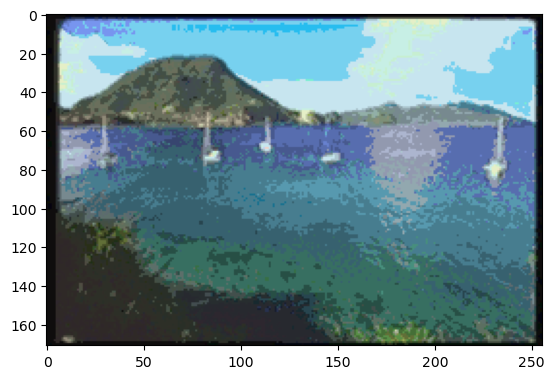

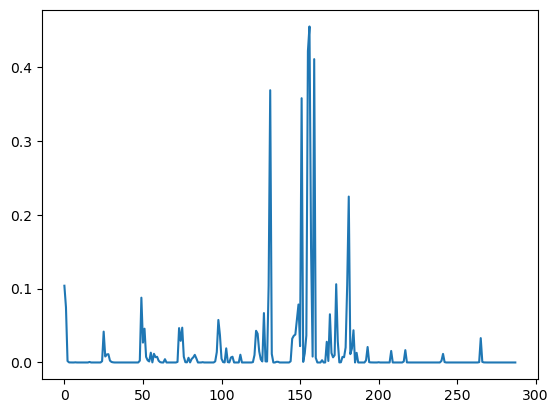

most prev:  [(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


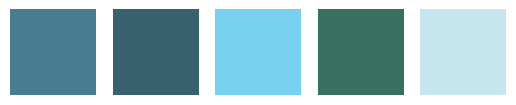

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [5]:

PathImage = './Base/Paysages'  # to be completed
nom = '67.png'  # to be completed

# quantization parameters
nH = 12
nS = 3
nV = 8


filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)


# color palette computation
palette, palette2 = setColors( nH, nS , nV );
print("palette: ", palette.shape)
# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
print("most prev: ",hsv_most_prevalent)
display5mainColors(histo, palette)

print(hsv_most_prevalent)

5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.



---------PAYSAGE WITH HIGH SATURATION AND VALUE--------------------------------------------------------





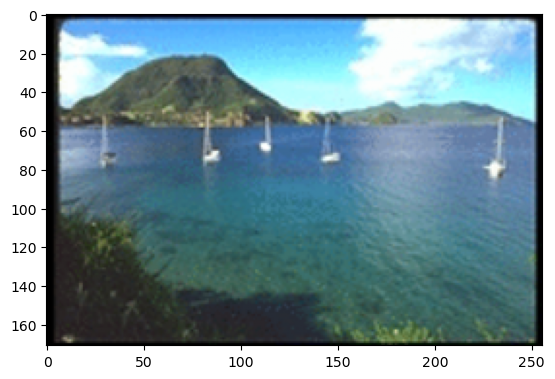

palette:  (9025, 3)


C:\Users\giuli\AppData\Local\Temp\ipykernel_32484\1769635714.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]


253.6578947368421


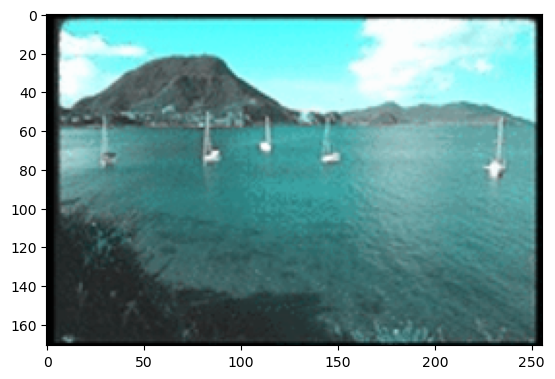

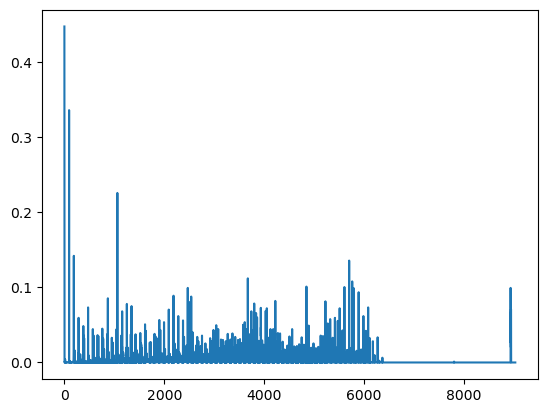

most prev:  [(0, 0, 0), (0, 0, 94), (0, 11, 15), (0, 1, 94), (0, 59, 94)]


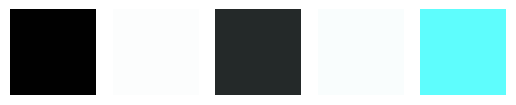

[(0, 0, 0), (0, 0, 94), (0, 11, 15), (0, 1, 94), (0, 59, 94)]



---------SUNSET WITH ALTERED HUE, SATURATION AND VALUE--------------------------------------------------------





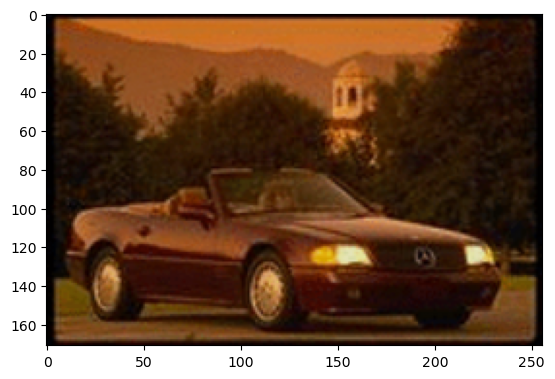

palette:  (8640, 3)
239.0625


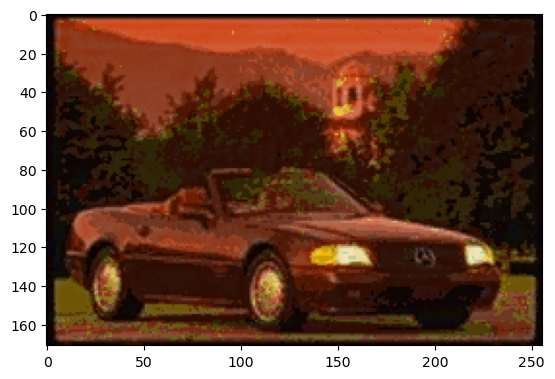

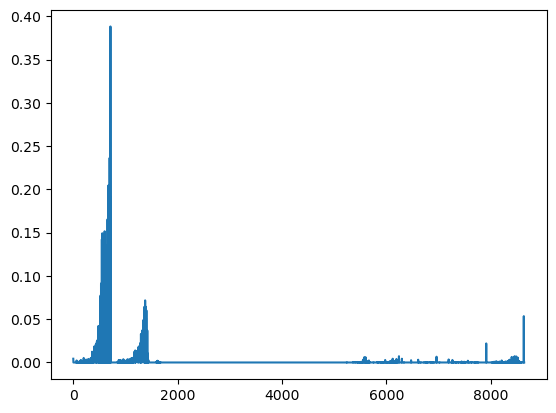

most prev:  [(0, 89, 0), (0, 87, 1), (0, 89, 1), (0, 86, 1), (0, 84, 1)]


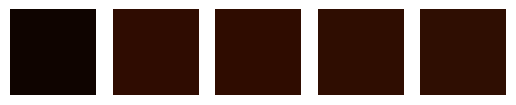

[(0, 0, 0), (0, 0, 94), (0, 11, 15), (0, 1, 94), (0, 59, 94)]


In [6]:
print("\n\n---------PAYSAGE WITH HIGH SATURATION AND VALUE--------------------------------------------------------\n\n\n")
PathImage_second = './Base/Paysages'  # to be completed
nom_second = '67.png'  # to be completed

# quantization parameters
nH_2 = 1
nS_2 = 95
nV_2 = 95


filename_second= nom_second;
I_2 = np.array(Image.open(PathImage_second + filename_second))
I_2 = I_2 / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I_2);
plt.show()

# conversion RGB->HSV
J_2 = rgb2hsv(I_2)


# color palette computation
palette_2, palette2_2 = setColors( nH_2, nS_2 , nV_2 );
print("palette: ", palette_2.shape)
# Image quantization (your function)
Iq_2, histo_2 = quantizeImage(J_2, nH_2, nS_2, nV_2)

# Visualisation of quantized image
viewQuantizedImage(Iq_2 , palette2_2)

# flat a 3D histogram to 1D
histo_2 = histo_2.flat

# Histogram normalization (your function)
histo_2 = normalize(histo_2)

plt.figure()
plt.plot(histo_2)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent_2 = (-histo_2).argsort()[:5]
hsv_most_prevalent_2 = [np.unravel_index(idx,( nH_2, nS_2 , nV_2 )) for idx in idx_most_prevalent_2]
print("most prev: ",hsv_most_prevalent_2)
display5mainColors(histo_2, palette_2)

print(hsv_most_prevalent_2)


print("\n\n\n---------SUNSET WITH ALTERED HUE, SATURATION AND VALUE--------------------------------------------------------\n\n\n")
PathImage_third = './Base/Sunsets'  # to be completed
nom_third = '56.png'  # to be completed

# quantization parameters
nH_3 = 12
nS_3 = 90
nV_3 = 8


filename_third= nom_third;
I_3 = np.array(Image.open(PathImage_third + filename_third))
I_3 = I_3 / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I_3);
plt.show()

# conversion RGB->HSV
J_3 = rgb2hsv(I_3)


# color palette computation
palette_3, palette2_3 = setColors( nH_3, nS_3 , nV_3 );
print("palette: ", palette_3.shape)
# Image quantization (your function)
Iq_3, histo_3 = quantizeImage(J_3, nH_3, nS_3, nV_3)

# Visualisation of quantized image
viewQuantizedImage(Iq_3 , palette2_3)

# flat a 3D histogram to 1D
histo_3 = histo_3.flat

# Histogram normalization (your function)
histo_3 = normalize(histo_3)

plt.figure()
plt.plot(histo_3)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent_3 = (-histo_3).argsort()[:5]
hsv_most_prevalent_3 = [np.unravel_index(idx,( nH_3, nS_3 , nV_3 )) for idx in idx_most_prevalent_3]
print("most prev: ",hsv_most_prevalent_3)
display5mainColors(histo_3, palette_3)

print(hsv_most_prevalent_2)


6) What can you say about the results?

The HSV schema is used to describe the way colors combine to create the spectrum we see in a closer way to how humans perceive color (with respect to, for instance, the RGB schema). \
It has three components: hue, saturation and value. 
- hue represents the colour type. The three chief hues in light are red, green and blue. Hue is usually represented in degrees (between 0 and 360), where red lies in 0, green in 120 and blue in 240.
- saturation describes their degree of vivideness, and it is identified by measuring the amount of gray mixed in the pure colour. The more the grayness in the picture, the lowest its saturation level.
- value describes their brighteness value, it's also called blackness value because it relates to the amplitude of a colour - the higher the value the closer the colour is to white. So this parameter describes the overall intensity of the light.

The first experiment I did, I changed the parameters of saturation and value to the extreme, and, as we can observe from the displayed result, the resulting image has the gray level close to zero (aas the saturation is very high), so we lose the shades of the picture and just see basic colors with high contrast. By choosing a high value of the parameter "value", we can see how much of the darker parts of the image are much lighter now.   

For the second result, I used a picture of the sunset, were all the colours verted around the orange/red. I altered the saturation value, making it very high, and kept the other parameters low. \
This results in the picture with a more sature level of colors (darker red instead of orange). Since the other parameters are low we can see that the predominant colors here instead of the orangy of the original picture, are now dark red/brown ones.

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [7]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = 1 # Set to False to compute the histogramm database

if not bcomputed:
    listImage = os.listdir(pathImage)
    #print(listImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print(imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")
    

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [8]:
def mse(hist1, hist2):
    """ Array*Array -> float
    """
    temp = 0
    for i,j in zip(hist1, hist2):
        a = np.square(i-j)
        temp += a
    return temp/len(hist1)


In [9]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def matrixSim(listHisto):
    S = np.zeros((listHisto.shape[0], listHisto.shape[0]))

    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            S[i,j] += 1-mse(listHisto[i],listHisto[j])
    return S

S = matrixSim(listHisto)


2. Display the matrix `S`  as an image. What can we say about this it ?

To define the similarity between two histograms (and so the two images that they represent), I compared it using the mean squared error formula. \
This means that for each couple of histograms, I computed the mean squared error of the two, which is the sum of the squared difference of the corresponding bins of the two histograms, divided by the number of bins. \
The lower the resulting number, the higher is the similarity between the two histograms (and images). 

Then, to create the similarity matrix, for each value obtained I consider the reciprocal of its normalized value, so that the values are all comparable to one another.

For the matrix's representation, I convert the value indicating the similarity between two histograms into a value between 0 and 255, and this way I am able to show it as a pixel in the gray colour scale. 

As we can observe from the displaying of the similarity matrix below, it is symmetrical, as the similarity between two histograms A and B is the same whatever the order is, so sim(histA, histB) = sim(histB, histA).

Another consideration is that we can clearly see the diagonal of the matrix, which represent the computation of the similarity of an image with itself. This similarity is equal to 1 - which corresponds to 255, the white pixel.

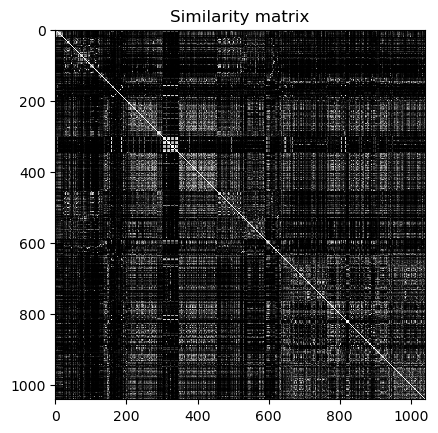

In [10]:
S_prime = S*(255/S.max())
plt.imshow(S_prime, interpolation='nearest', cmap='gray')
plt.title("Similarity matrix")
plt.show()

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

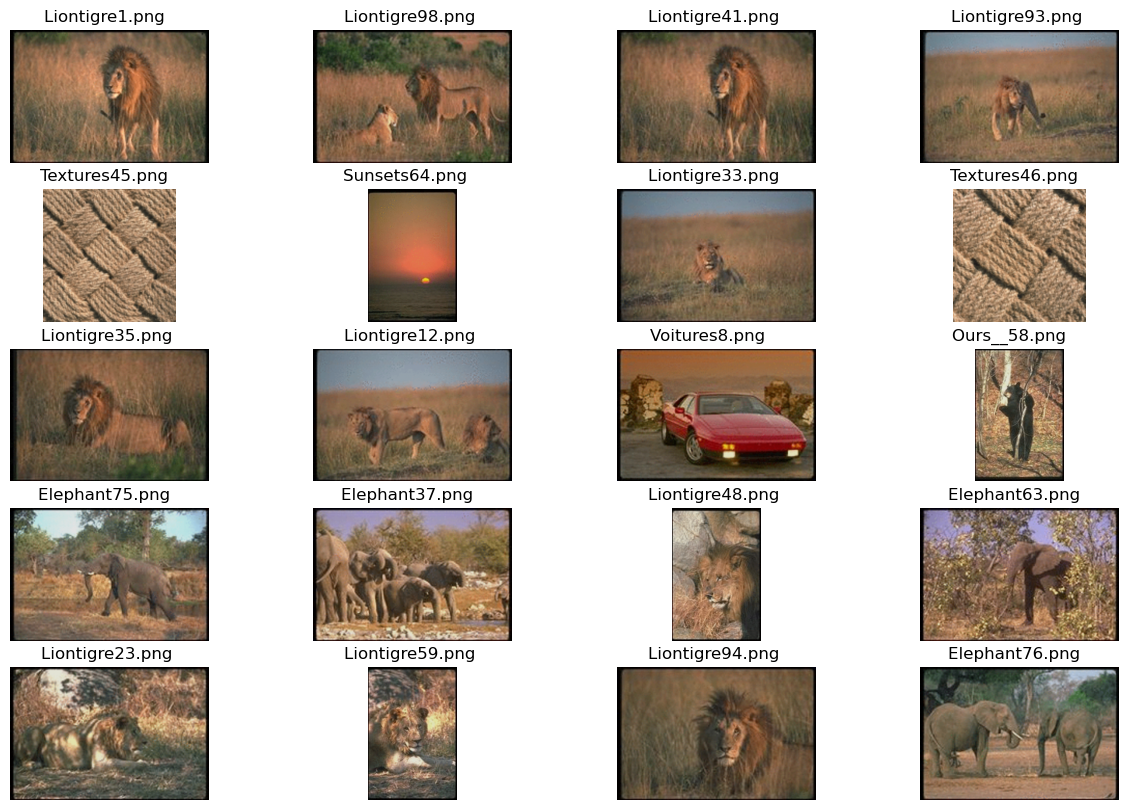

In [11]:
indexQuery = 349
display20bestMatches(S, indexQuery)


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


index of the randomly chosen picture:  206


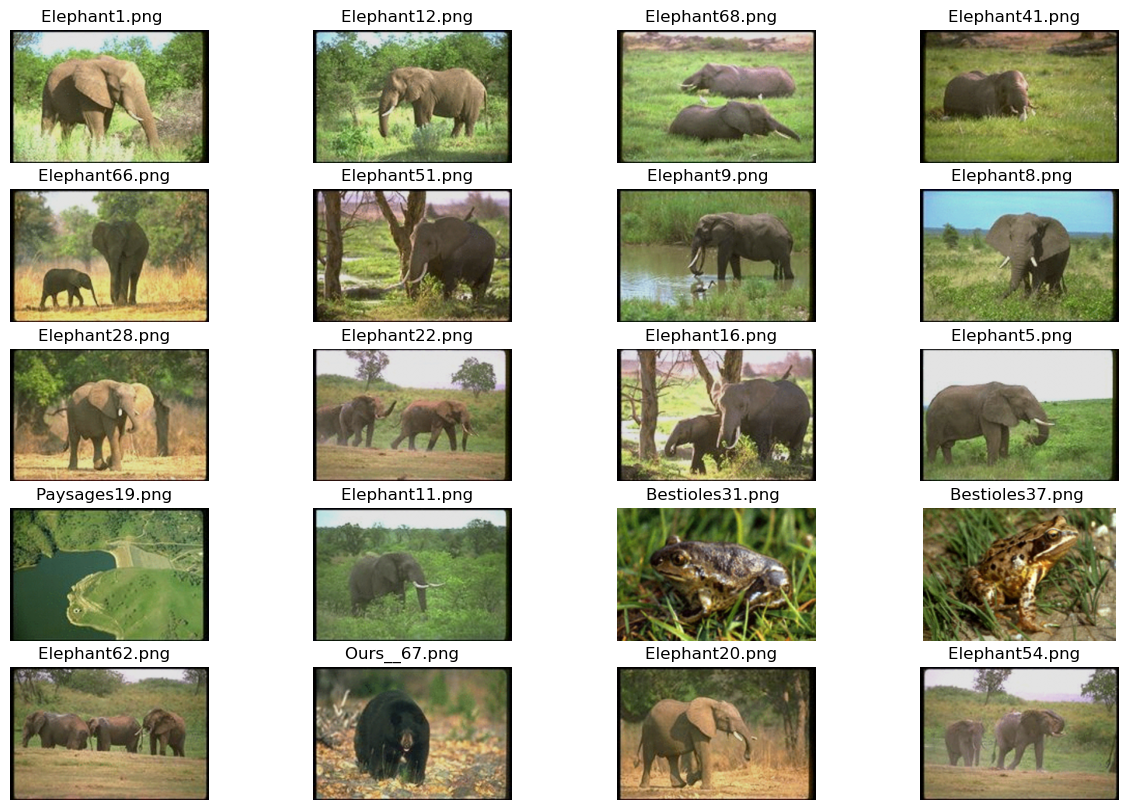

In [12]:
import random

result = np.random.randint(1, len(listHisto))

print("index of the randomly chosen picture: ",result)
display20bestMatches(S, result)

5. What can you say about the results ? What are the limitations and the advantages of this method ?

As can be seen, a large portion of the images found with the highest similarity rate are images depicting similar situations (for one image with lions, other images with lions). 

A limitation, however, may be the fact that hsv focuses more on the colour distribution and saturation of the image, so that images that depict something completely different but have a similar colour distribution (e.g. different pictures that are taken at sunset and therefore have similar colour tones) are also considered good matches of an image. 

This means that the model is a very powerful tool to find similar pictures in a dataset, but it does not work for image classification. \
For example in the randomly generated query the chosen picture is the one of an elephant and there is a lot of green given by the landscape. \
Out of the 20 best matches, 16 also depict elephants, but there is also a picture of a green landscape, two pictures of green frogs in the grass and a picture of a bear in the forest (which have similar colour distribution and so are seen as a good match by the model).
